In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import gc
import time
import pickle
import seaborn as sns
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn import preprocessing 
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

In [3]:
# 将index设置为ID，以避免稍后删除它
test  = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')

#删除特异值
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]
#售价低于0,用中值填充
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

#清除重复行
train.drop_duplicates(subset=["date","date_block_num","shop_id","item_id","item_price","item_cnt_day"],keep='first',inplace=True)

##有几家商店是彼此的复制品,修复训练集和测试集将其更改为同一商店编号
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#清除训练集中在测试集中不存在的商店
train = train.merge(test[['shop_id']].drop_duplicates(), how = 'inner')

In [4]:
#shops.csv数据--------------------------------------------------
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
#分解出商店所在城市
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_city'] = LabelEncoder().fit_transform(shops['city'])
#分解出商店经营类型
shops['shop_name1'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_type'] = shops['shop_name1'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops["shop_type"] = shops["shop_type"].map({'NO_DATA': 0 ,'мтрц': 1 ,'тк': 2 ,'трк': 3 ,'трц': 4 ,'тц': 5 })
#更新数据
shops = shops[['shop_id','shop_city','shop_type']]

#item_categories.csv数据--------------------------------------------------
cats = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
#分解出商品所在类别
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['item_type'] = LabelEncoder().fit_transform(cats['type'])
# # 如果子类型是nan，就输入
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['item_subtype'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','item_type','item_subtype']]

#items.csv数据--------------------------------------------------
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')

items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

items['name_1'] = LabelEncoder().fit_transform(items['name_1'])
items['name_2'] = LabelEncoder().fit_transform(items['name_2'])
items['name_3'] = LabelEncoder().fit_transform(items['name_3'])

items = items[['item_id','item_category_id','name_1','name_2','name_3']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
#对于每个月，我们从该月的所有商店/项目组合创建一个网格
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in train['date_block_num'].unique():
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

#求每月在该商店该商品的售出量:item_cnt_month
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

#要使用时间技巧，请将测试对附加到矩阵中
test['date_block_num'] = 34
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
del test
gc.collect()

17

In [6]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')

del shops,items,cats
gc.collect()

22

In [7]:
#添加月,日变量
matrix['year']  =  matrix['date_block_num']/12+2013
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days']  = matrix['month'].map(days).astype(np.int8)
matrix['year']  = matrix['year'].astype(np.int16)
print(matrix.shape)
matrix.head(3)

(8860658, 15)


,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,name_1,name_2,name_3,item_type,item_subtype,year,month,days
0,0,2,19,0.0,0,5,40,19,4,42,11,4,2013,0,31
1,0,2,27,1.0,0,5,19,27,77,42,5,10,2013,0,31
2,0,2,28,0.0,0,5,30,28,108,42,8,55,2013,0,31


In [8]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

def tianjia1(list_names,list_num):
    global matrix
    str1 = list_names[0]
    for i in range(1,len(list_names)):
        str1 = str1+'_and_'+list_names[i]
    str1 = str1+'_avg_item_cnt'
    
    group = matrix.groupby(list_names).agg({'item_cnt_month': ['mean']})
    group.columns = [str1]
    group.reset_index(inplace=True)

    matrix = pd.merge(matrix, group, on=list_names, how='left')
    matrix[str1] = matrix[str1].astype(np.float16)
    matrix = lag_feature(matrix, list_num, str1)
    matrix.drop([str1], axis=1, inplace=True)

In [9]:
#1时间item_cnt_month_lag
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')

tianjia1(['date_block_num'],[1])

tianjia1(['date_block_num', 'item_id'],[1,2,3])
tianjia1(['date_block_num', 'shop_id'],[1,2,3])

tianjia1(['date_block_num', 'item_category_id'],[1])
tianjia1(['date_block_num', 'shop_id', 'item_category_id'],[1])
tianjia1(['date_block_num', 'shop_id', 'item_id'],[1])

print(matrix.shape)
matrix.head(3)

(8860658, 28)


,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,name_1,name_2,name_3,item_type,item_subtype,year,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_block_num_avg_item_cnt_lag_1,date_block_num_and_item_id_avg_item_cnt_lag_1,date_block_num_and_item_id_avg_item_cnt_lag_2,date_block_num_and_item_id_avg_item_cnt_lag_3,date_block_num_and_shop_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_avg_item_cnt_lag_2,date_block_num_and_shop_id_avg_item_cnt_lag_3,date_block_num_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1
0,0,2,19,0.0,0,5,40,19,4,42,11,4,2013,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,5,19,27,77,42,5,10,2013,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,5,30,28,108,42,8,55,2013,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [11]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1693.9870529174805

In [12]:
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [13]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df
matrix = matrix[matrix.date_block_num >3]
matrix = fill_na(matrix)
matrix = downcast_dtypes(matrix)
time.time() - ts
print(matrix.shape)
matrix.head(3)

(7756739, 32)


,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_type,item_category_id,name_1,name_2,name_3,item_type,item_subtype,year,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_block_num_avg_item_cnt_lag_1,date_block_num_and_item_id_avg_item_cnt_lag_1,date_block_num_and_item_id_avg_item_cnt_lag_2,date_block_num_and_item_id_avg_item_cnt_lag_3,date_block_num_and_shop_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_avg_item_cnt_lag_2,date_block_num_and_shop_id_avg_item_cnt_lag_3,date_block_num_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1,delta_price_lag,item_shop_last_sale,item_last_sale,item_first_sale
1103919,4,2,27,0.0,0,5,19,27,77,42,5,10,2013,4,31,0.0,0.0,0.0,0.292969,0.027771,0.083313,0.083313,0.076233,0.095459,0.063599,0.743652,0.500000,0.0,0.345459,1,1,4
1103920,4,2,28,0.0,0,5,30,28,108,42,8,55,2013,4,31,0.0,0.0,0.0,0.292969,0.111084,0.083313,0.194458,0.076233,0.095459,0.063599,1.081055,0.399902,0.0,0.259521,-1,1,4
1103921,4,2,29,0.0,0,5,23,29,124,42,5,16,2013,4,31,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-1,4,4


In [14]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_type', 'item_category_id', 'name_1', 'name_2', 'name_3',
       'item_type', 'item_subtype', 'year', 'month', 'days',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_block_num_avg_item_cnt_lag_1',
       'date_block_num_and_item_id_avg_item_cnt_lag_1',
       'date_block_num_and_item_id_avg_item_cnt_lag_2',
       'date_block_num_and_item_id_avg_item_cnt_lag_3',
       'date_block_num_and_shop_id_avg_item_cnt_lag_1',
       'date_block_num_and_shop_id_avg_item_cnt_lag_2',
       'date_block_num_and_shop_id_avg_item_cnt_lag_3',
       'date_block_num_and_item_category_id_avg_item_cnt_lag_1',
       'date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1',
       'date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1',
       'delta_price_lag', 'item_shop_last_sale', 'item_last_sale',
       'item_first_sale'],
      dtype='object')

In [15]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7756739 entries, 1103919 to 8860657
Data columns (total 32 columns):
 #   Column                                                              Dtype  
---  ------                                                              -----  
 0   date_block_num                                                      int16  
 1   shop_id                                                             int16  
 2   item_id                                                             int16  
 3   item_cnt_month                                                      float16
 4   shop_city                                                           int16  
 5   shop_type                                                           int16  
 6   item_category_id                                                    int16  
 7   name_1                                                              int16  
 8   name_2                                                            

In [16]:
matrix.to_pickle('data2.pkl')
del matrix
gc.collect()

0

In [17]:
data = pd.read_pickle('data2.pkl')
data = data[[
    'date_block_num', 
    'shop_id', 
    'item_id', 
    'item_cnt_month', 
#     'shop_city',
    'shop_type', 
    'item_category_id',
#     'item_type', 
    'name_1',
    'name_2',
    'name_3',
    'item_subtype',
    'year',
    'month',
    'days', 
    'item_cnt_month_lag_1', 
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3', 
    'date_block_num_avg_item_cnt_lag_1',
    'date_block_num_and_item_id_avg_item_cnt_lag_1',
    'date_block_num_and_item_id_avg_item_cnt_lag_2',
    'date_block_num_and_item_id_avg_item_cnt_lag_3',
    'date_block_num_and_shop_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_avg_item_cnt_lag_2',
    'date_block_num_and_shop_id_avg_item_cnt_lag_3',
    'date_block_num_and_item_category_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1',
    'delta_price_lag', 
    'item_shop_last_sale', 
    'item_last_sale',
    'item_first_sale'
]]




X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_zong = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_zong = data[data.date_block_num < 33]['item_cnt_month']

# 总得切分一下数据咯（训练集和测试集）
X_train, X_test, y_train, y_test = train_test_split(X_valid,Y_valid,test_size = 0.25)

X_tests = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

xx = pd.concat([X_zong,X_train])
yy = pd.concat([Y_zong,y_train])

del data,X_valid,Y_valid,X_train,y_train,X_zong,Y_zong
gc.collect()

0

In [18]:
print(xx.shape)
xx.head(3)

(7487088, 29)


,date_block_num,shop_id,item_id,shop_type,item_category_id,name_1,name_2,name_3,item_subtype,year,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_block_num_avg_item_cnt_lag_1,date_block_num_and_item_id_avg_item_cnt_lag_1,date_block_num_and_item_id_avg_item_cnt_lag_2,date_block_num_and_item_id_avg_item_cnt_lag_3,date_block_num_and_shop_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_avg_item_cnt_lag_2,date_block_num_and_shop_id_avg_item_cnt_lag_3,date_block_num_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1,delta_price_lag,item_shop_last_sale,item_last_sale,item_first_sale
1103919,4,2,27,5,19,27,77,42,10,2013,4,31,0.0,0.0,0.0,0.292969,0.027771,0.083313,0.083313,0.076233,0.095459,0.063599,0.743652,0.500000,0.0,0.345459,1,1,4
1103920,4,2,28,5,30,28,108,42,55,2013,4,31,0.0,0.0,0.0,0.292969,0.111084,0.083313,0.194458,0.076233,0.095459,0.063599,1.081055,0.399902,0.0,0.259521,-1,1,4
1103921,4,2,29,5,23,29,124,42,16,2013,4,31,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-1,4,4


In [19]:
xx.to_pickle('xx.pkl')
yy.to_pickle('yy.pkl')

X_test.to_pickle('X_test.pkl')
y_test.to_pickle('y_test.pkl')

In [20]:
ts = time.time()
model = XGBRegressor(
    max_depth=10,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.9, 
    subsample=0.8, 
    num_round = 10000,
    nthread = 16,
    eta=0.1,
    seed=1)

model.fit(xx, yy, eval_metric="rmse", eval_set=[(xx,yy),(X_test,y_test)], verbose=True, early_stopping_rounds = 10)
time.time() - ts

[13:02:46] WARNING: ../src/learner.cc:541: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.18483	validation_1-rmse:1.04795
[1]	validation_0-rmse:1.13941	validation_1-rmse:1.01267
[2]	validation_0-rmse:1.09278	validation_1-rmse:0.97625
[3]	validation_0-rmse:1.05446	validation_1-rmse:0.94691
[4]	validation_0-rmse:1.02078	validation_1-rmse:0.92119
[5]	validation_0-rmse:0.99191	validation_1-rmse:0.90057
[6]	validation_0-rmse:0.96780	validation_1-rmse:0.88380
[7]	validation_0-rmse:0.94946	validation_1-rmse:0.87271
[8]	validation_0-rmse:0.93050	validation_1-rmse:0.85994
[9]	validation_0-rmse:0.91499	validation_1-rmse:0.85013
[10]	validation_0-rmse:0.90160	validation_1-rmse:0.84117
[11]	validation_0-rmse:0.89130	validation_1-rmse:0.835

2469.833024740219

In [21]:
Y_tests = model.predict(X_tests).clip(0, 20)

In [22]:
test  = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_tests
})
submission.to_csv('xgb_submission1.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

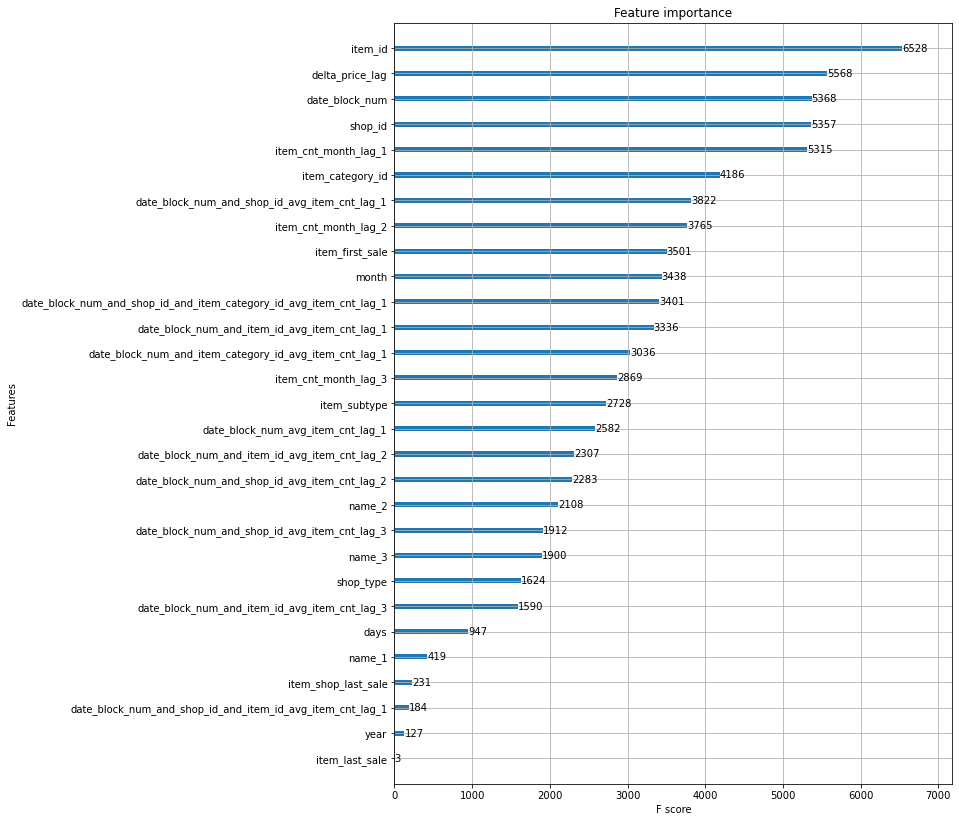

In [23]:
plot_features(model, (10,14))